# Introduction

This project aims to develop a robust predictive model for estimating housing prices based on key features like property size, location, and number of rooms. By leveraging statistical analysis and modeling techniques, we explore the relationships between various property characteristics and their impact on market value. The resulting model will serve as a reliable, data-driven valuation tool, providing valuable insights for the real estate industry to estimate property prices with precision

The *Housing Price Prediction*$\text{}^{1}$ dataset observed provides key features for predicting house prices, including area, bedrooms, bathrooms, stories, amenities like air conditioning and parking, and information on furnishing status. It enables analysis and modeling to understand the factors impacting house prices and develop accurate predictions in real estate markets.

This dataset contains the following columns:
- **Price**: The price of the house.
- **Area**: The total area of the house in square feet.
- **Bedrooms**: The number of bedrooms in the house.
- **Bathrooms**: The number of bathrooms in the house.
- **Stories**: The number of stories in the house.
- **Mainroad**: Whether the house is connected to the main road (Yes/No).
- **Guestroom**: Whether the house has a guest room (Yes/No).
- **Basement**: Whether the house has a basement (Yes/No).
- **Hot water heating**: Whether the house has a hot water heating system (Yes/No).
- **Airconditioning**: Whether the house has an air conditioning system (Yes/No).
- **Parking**: The number of parking spaces available within the house.
- **Prefarea**: Whether the house is located in a preferred area (Yes/No).
- **Furnishing status**: The furnishing status of the house (Fully Furnished, Semi-Furnished, Unfurnished).


# Library Imports and Functions

In [1]:
# import necessary libraries
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import DomainWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import warnings

pd.set_option('future.no_silent_downcasting', True)
warnings.filterwarnings('ignore', category=FutureWarning, module='statsmodels.genmod.families.links')
warnings.filterwarnings("ignore", category=DomainWarning)

In [2]:

# function to create histograms in a given row/column
def create_histogram(ax, data, title, bins):
    ax.hist(data, bins=bins)
    ax.set_title(title)

In [3]:

# function to create scatter plots with correlation and regression line
def create_scatterplot(ax, df, x_col, y_col, title):
    m, b = np.polyfit(df[x_col], df[y_col], 1) # get linear regression
    ax.scatter(df[x_col], df[y_col]) # scatter plot
    ax.plot(df[x_col], m * df[x_col] + b, color='red') # plot the regression line
    corr = round(np.corrcoef(df[x_col], df[y_col])[0, 1], 2)# get correlation coefficient
    ax.set_title(f'{title} vs. {y_col}; $\\mathit{{r}}$ = {corr:.2f}')     # set the title with correlation coefficient
    ax.set_xlabel(title)  # set x and y labels
    ax.set_ylabel(y_col)

In [4]:

# create scatter plots for each variable in plots_info
def plot_correlation_grid(df, y_col, plots_info):
    fig, axs = plt.subplots(3, 4, figsize=(16, 12)) # create a 3x4 grid for the scatter plots
    for i, (x_col, title, _) in enumerate(plots_info): # loop through plots_info and axs to create scatter plots with correlation
        row, col = divmod(i, 4)  # Calculate row and column indices
        create_scatterplot(axs[row, col], df, x_col, y_col, title)
    plt.tight_layout()  # ddjust layout for better spacing
    plt.show()  # display the plots

In [5]:

# function to plot model
def plot_scatter(title, y, pred, r2):
    # scatter plot of actual vs predicted prices from the OLS model
    plt.scatter(y, pred, color='blue', label='Predicted vs Actual')  # Use predictions
    
    # adding a perfect fit line (y = x)
    line = np.linspace(min(y), max(y), 100)
    plt.plot(line, line, color='red', label='Perfect Fit Line')
    
    # fitting the regression line to the actual vs predicted values
    regression_line = np.polyfit(y, pred, 1)  # Fit line based on OLS predictions
    plt.plot(y, np.polyval(regression_line, y), color='green', label='Fitted Regression Line')
    
    # labels, title, and legend
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title(f"{title}: Actual vs Predicted Prices - R-Square: {r2:.2f}")
    plt.legend()
    plt.show()

# Data Loading and Initial Overview

In [6]:
# data import
housing_raw = pd.read_csv('housing.csv')

In [7]:
# explore first five items of the data
housing_raw.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [8]:
# shape of the data; (rows, columns)
housing_raw.shape

(545, 13)

In [9]:
housing_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [10]:
# statistical description of the data
housing_raw.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


# Data Cleaning and Preparation

In [11]:
# removes any row with at least one missing value
housing = housing_raw.dropna()

#  Exploratory Data Analysis 

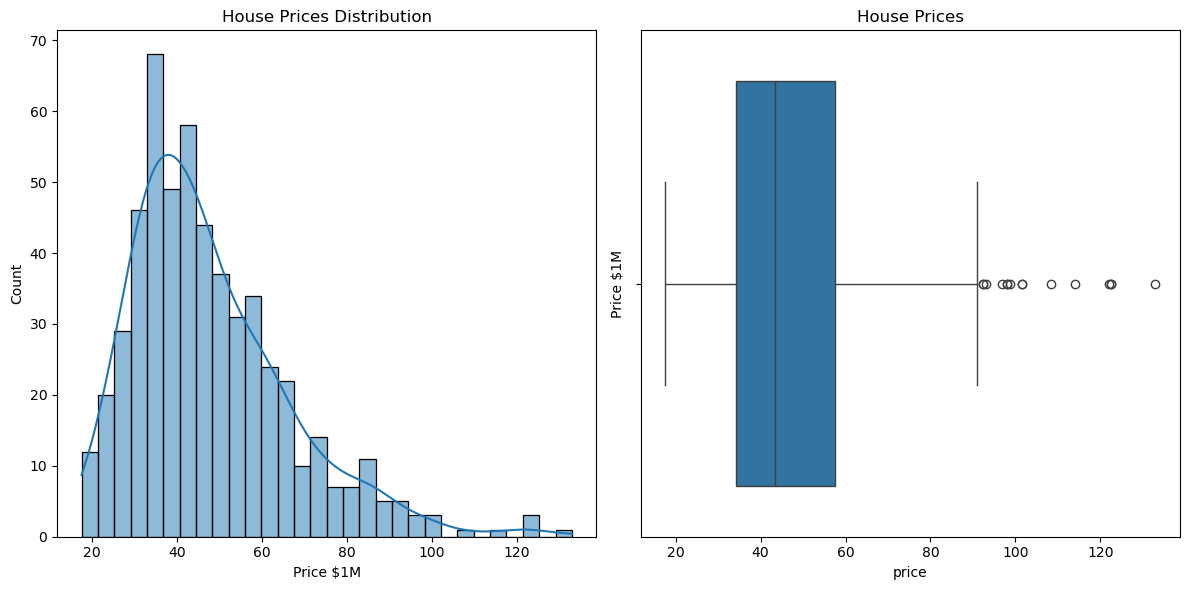

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

housing['price'] = housing['price']/100000
# first plot - Histogram with KDE
sns.histplot(housing['price'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('House Prices Distribution')
axs[0].set_xlabel('Price $1M')

# second plot - Boxplot
sns.boxplot(x='price', data=housing, ax=axs[1])
axs[1].set_title('House Prices')
axs[1].set_ylabel('Price $1M')

plt.tight_layout()  # adjusts the spacing of histograms
plt.show()

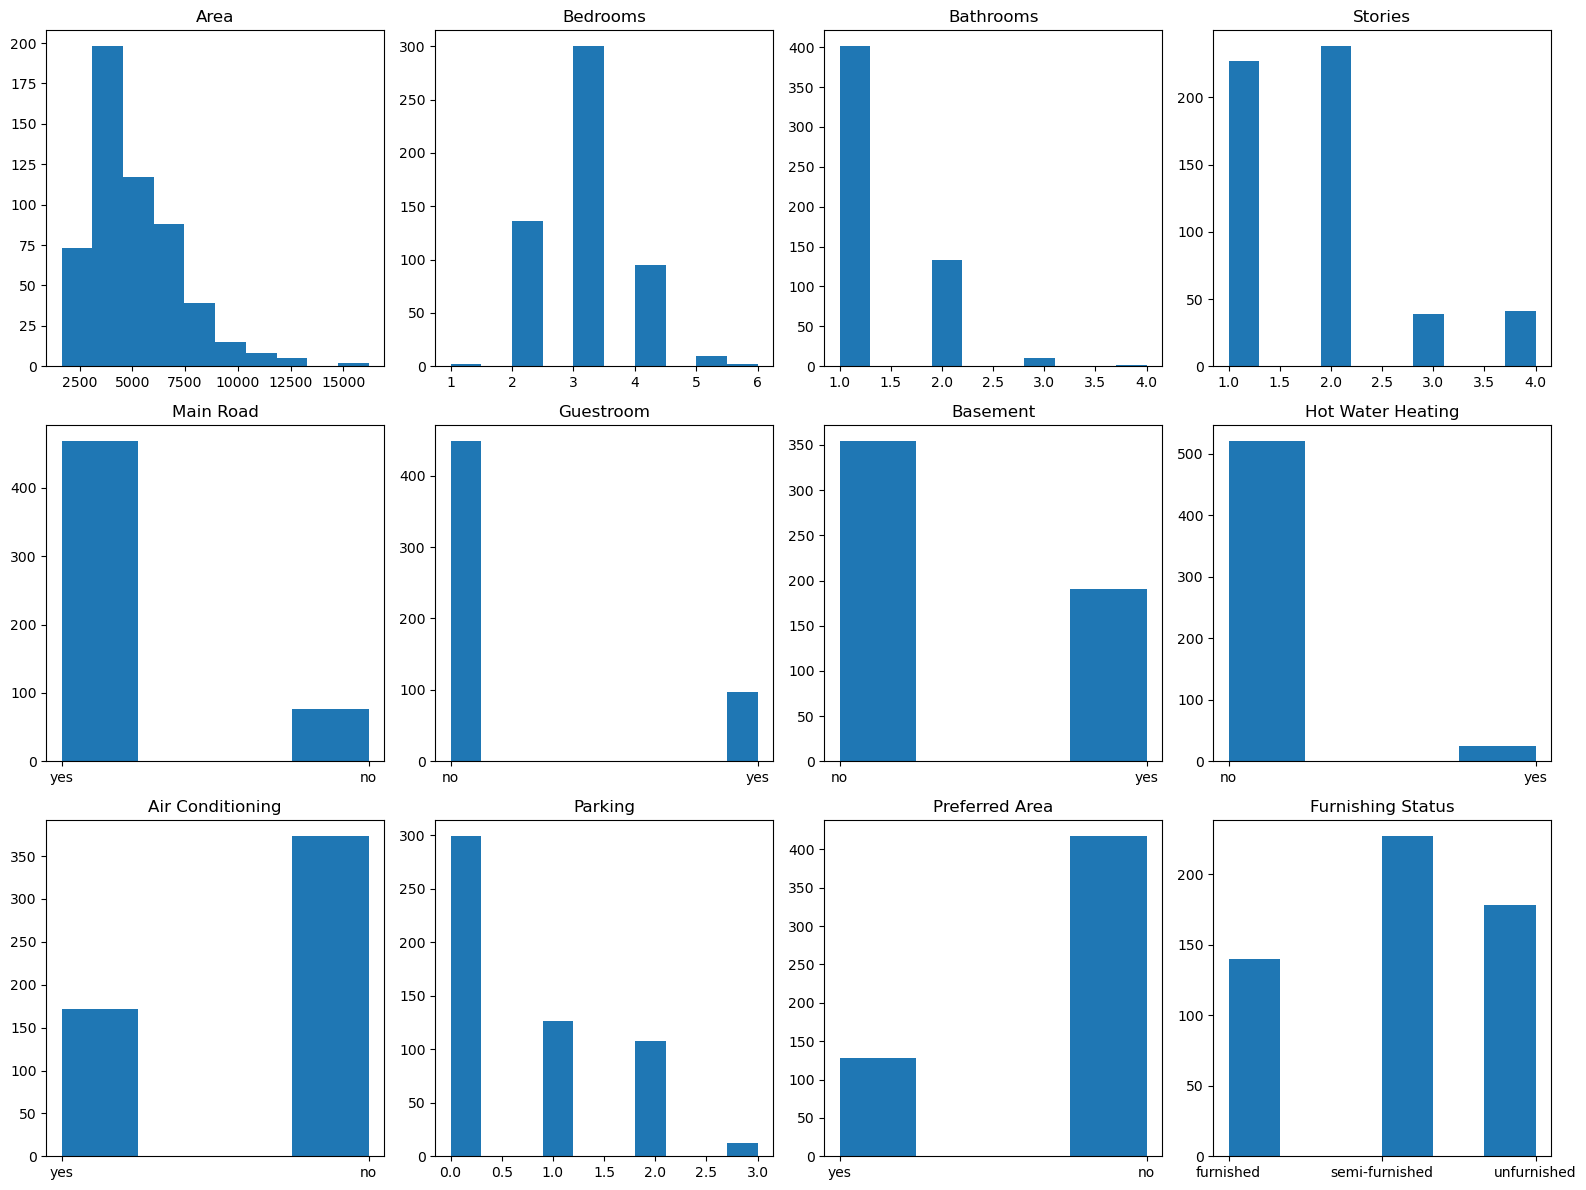

In [13]:

fig, axs = plt.subplots(3, 4, figsize=(16, 12)) # create a 3x4 grid for 12 variables

plots_info = [ # list of column names, titles, and number of bins for each plot
    ('area', 'Area', 10),
    ('bedrooms', 'Bedrooms', 10),
    ('bathrooms', 'Bathrooms', 10),
    ('stories', 'Stories', 10),
    ('mainroad', 'Main Road', 4),
    ('guestroom', 'Guestroom', 10),
    ('basement', 'Basement', 4),
    ('hotwaterheating', 'Hot Water Heating', 4),
    ('airconditioning', 'Air Conditioning', 4),
    ('parking', 'Parking', 10),
    ('prefarea', 'Preferred Area', 4),
    ('furnishingstatus', 'Furnishing Status', 6)
]

for i, (column, title, bins) in enumerate(plots_info): # loop through plots_info and axs to create the histograms
    row, col = divmod(i, 4)  # calculate row and column indices
    create_histogram(axs[row, col], housing[column], title, bins)

plt.tight_layout() # adjusts layout for better spacing
plt.show() # display the plots

In [14]:
mappings = { # dictionary of mappings for categorical values
    'yes': 1,
    'no': 0,
    'furnished': 2,
    'semi-furnished': 1,
    'unfurnished': 0
}

binary_columns = ['mainroad', # columns needing mapping
                  'guestroom', 
                  'basement', 
                  'hotwaterheating', 
                  'airconditioning', 
                  'parking', 
                  'prefarea']

housing[binary_columns] = housing[binary_columns].replace(mappings).astype(int) # apply mapping
housing['furnishingstatus'] = housing['furnishingstatus'].replace(mappings).astype(int) # apply the mapping for furnishingstatus column

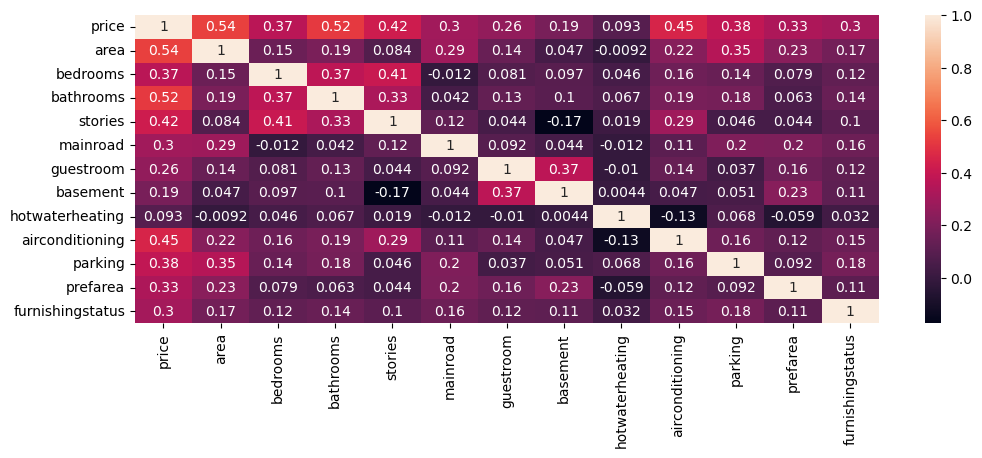

price               1.000000
area                0.535997
bathrooms           0.517545
airconditioning     0.452954
stories             0.420712
parking             0.384394
bedrooms            0.366494
prefarea            0.329777
furnishingstatus    0.304721
mainroad            0.296898
guestroom           0.255517
basement            0.187057
hotwaterheating     0.093073
Name: price, dtype: float64

In [15]:
# build a correlation matrix
corr_matrix = housing.corr()

fig, ax = plt.subplots(figsize=(12,4))        
sns.heatmap(corr_matrix, annot=True)
plt.show()

corr_matrix = corr_matrix['price'].sort_values(ascending=False)
display(corr_matrix)

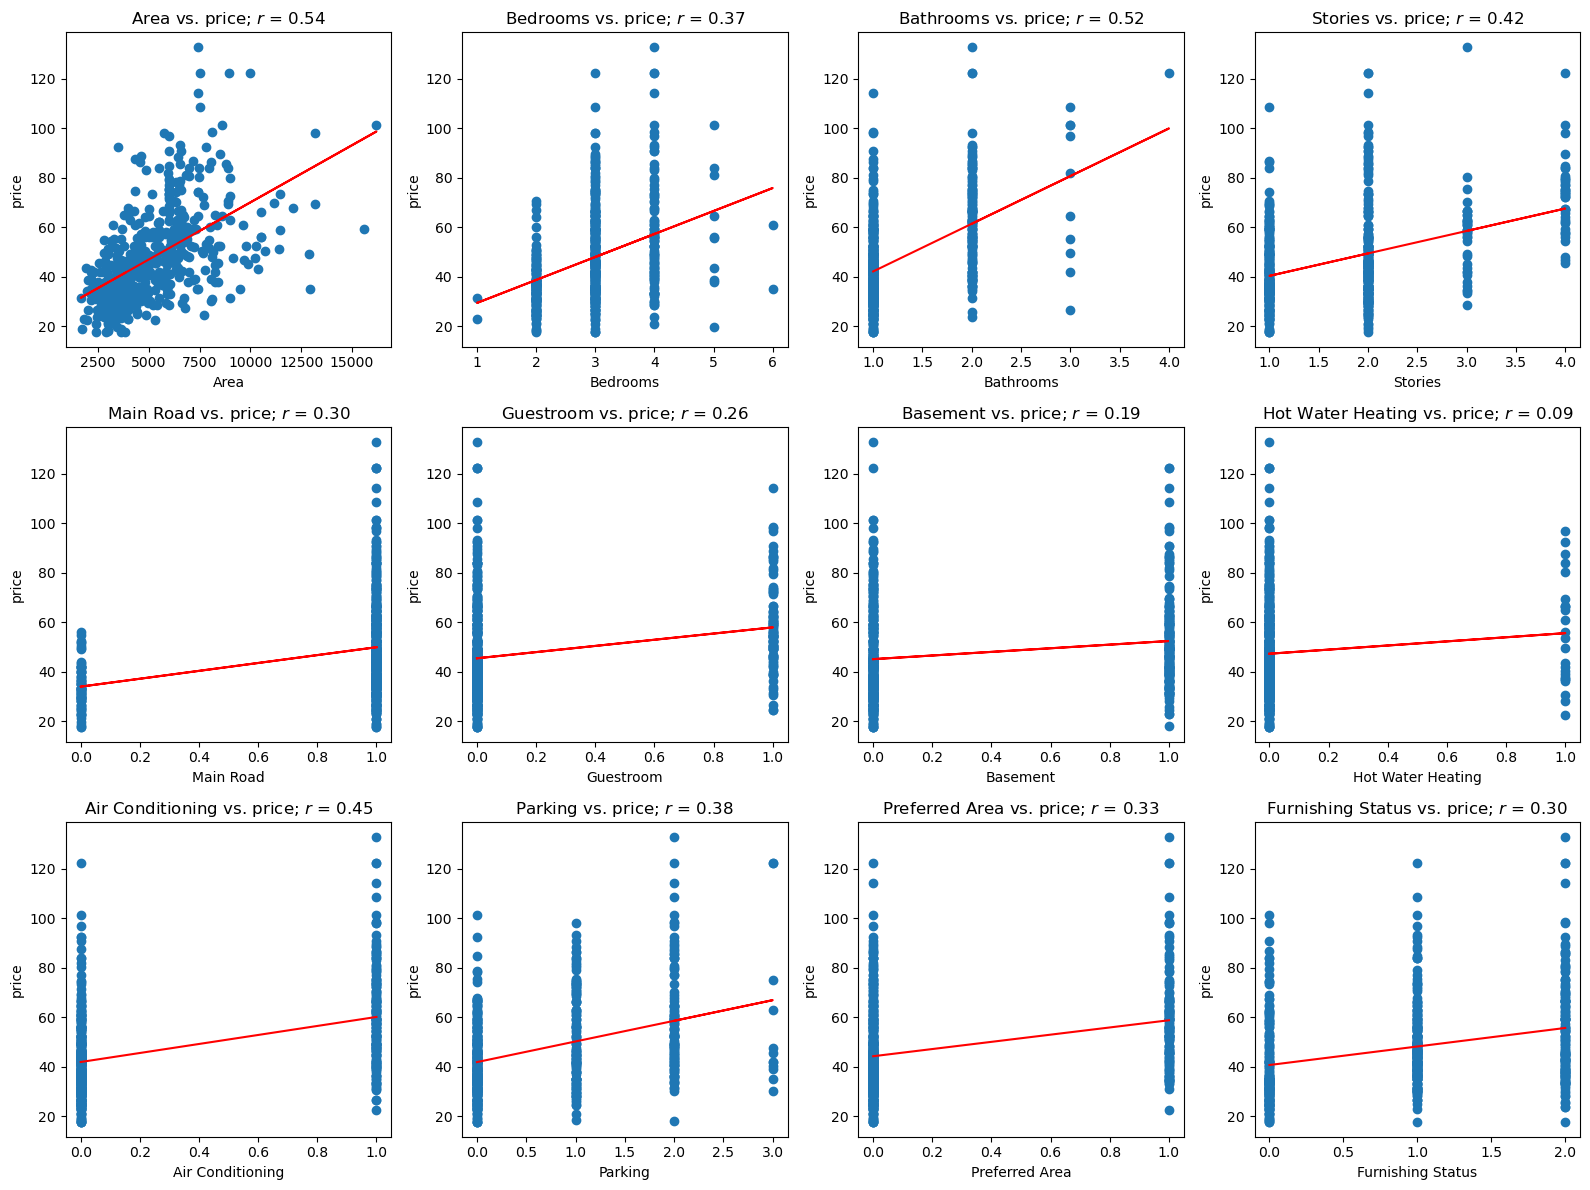

In [16]:
y_col = 'price' # y_col
plot_correlation_grid(housing, y_col, plots_info) # call the function with your DataFrame and the list of variables

# Model Selection

## Data Preprocessing

In [17]:

# define features 
X = housing.drop(columns=['price']) # everything
y = housing['price'] # define dependent variable

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

## Ordinary Least Squares (OLS)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     69.15
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           1.51e-86
Time:                        16:40:22   Log-Likelihood:                -1411.1
No. Observations:                 381   AIC:                             2848.
Df Residuals:                     368   BIC:                             2900.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.7190      2.656  

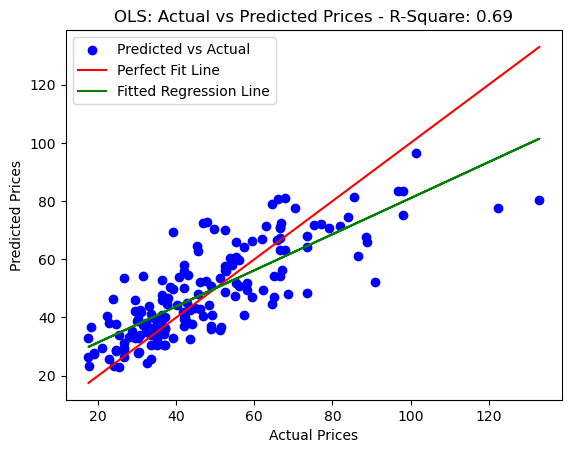


OLS - MAE: 9.255435483156553, RMSE: 12.389704429194621, R-squared: 0.6435419628959109


In [18]:

X_train_ols = sm.add_constant(X_train)  # adding a constant term for OLS
X_test_ols = sm.add_constant(X_test)

# train the OLS model
ols_model = sm.OLS(y_train, X_train_ols).fit()

# make predictions
ols_predictions = ols_model.predict(X_test_ols)

# print OLS summary
print(ols_model.summary())

# save OLS performance metrics
ols_mae = mean_absolute_error(y_test, ols_predictions)
ols_rmse = np.sqrt(mean_squared_error(y_test, ols_predictions))
ols_r2 = r2_score(y_test, ols_predictions)

plot_scatter("OLS", y_test, ols_predictions, ols_model.rsquared) # plot scatterplot
print(f"\nOLS - MAE: {ols_mae}, RMSE: {ols_rmse}, R-squared: {ols_r2}") # Report test data R-squared

# Model Analysis

In [19]:
print(f'\nOur OLS Regression model achieved an R-Squared of {ols_model.rsquared:.2f},')
print(f'which suggests that it explains {(ols_model.rsquared * 100):.0f}% of the variance in housing prices.')


Our OLS Regression model achieved an R-Squared of 0.69,
which suggests that it explains 69% of the variance in housing prices.


### ***Best Model for Predicting House Prices:*** 
Based on the analysis, the Ordinary Least Squares (OLS) Regression model performed the best, as indicated by its R-squared and RMSE values. OLS is an intuitive and easily interpretable linear model, which is beneficial when understanding the relationship between house prices and the selected features.

***OLS Regression*** works well for this dataset because the relationships between features and house prices appear to be primarily linear, and the model provides straightforward insights into how each feature affects the target variable. OLS also has the advantage of being easily interpretable. Each coefficient provides insight into how much a change in a particular feature will impact the house price, making it valuable for decision-makers who require transparent and explainable models.


### ***Improvements***

Although OLS performed well, the model's performance can still be improved by adding more relevant features. For example, we might explore including external features like proximity to schools, public transportation, or crime rates. These additional features could enhance the predictive power of the model by adding more contextual information about house prices. Another area to improve OLS performance is handling outliers more carefully. Removing or capping extreme values can improve the accuracy and stability of the predictions.

# Conclusion and Recommendations

### ***Applications***

- Real Estate Firms: The OLS model can help real estate agents predict property prices based on a linear relationship with features like area, number of bedrooms, and amenities. The interpretability of OLS makes it easier for non-technical stakeholders to understand the model’s output and make data-driven decisions.
- Mortgage Lenders: Banks and mortgage lenders could use the OLS model to estimate property values when issuing loans. The model’s straightforward nature helps in justifying loan amounts based on the feature contributions to house prices.
- Policymakers: OLS can help government agencies in understanding housing market dynamics and making policy decisions about urban development, housing affordability, or taxation.

### ***Future Work***

**Adding More Features**: As mentioned, gathering more external features that could impact house prices would be a valuable next step. Potential features include:
- Proximity to schools or parks.
- Crime rates in the area.
- Local amenities (shopping centers, restaurants, etc.).
- Economic indicators such as median household income in the neighborhood.
These features can provide additional context and help the OLS model produce even more accurate predictions.

**Model Monitoring**: Housing market trends change over time due to external factors such as economic conditions, changes in demand, and urban development. Monitoring the performance of the OLS model over time is crucial to ensure it remains accurate.

**Periodic Retraining**: As new housing data becomes available, the model should be retrained periodically to ensure it reflects current market trends. This is particularly important in fast-changing housing markets where historical data might become outdated.

# Appendix

## Generalized Linear Model (GLM) with a Gamma distribution 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                  381
Model:                            GLM   Df Residuals:                      368
Model Family:                   Gamma   Df Model:                           12
Link Function:                    log   Scale:                        0.038048
Method:                          IRLS   Log-Likelihood:                -1357.4
Date:                Wed, 16 Oct 2024   Deviance:                       13.758
Time:                        16:40:22   Pearson chi2:                     14.0
No. Iterations:                    10   Pseudo R-squ. (CS):             0.9050
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.7826      0.052  

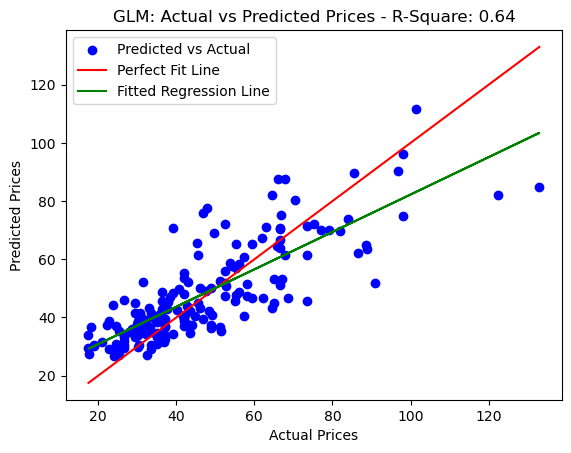


OLS - GML: 9.235376358350146, RMSE: 12.383931558697036, R-squared: 0.643874062292534


In [20]:
X_train_glm = X_train_ols
X_test_glm = X_test_ols

glm_model = sm.GLM(y_train, X_train_glm, family=sm.families.Gamma(link=sm.families.links.log() # log link function for right skewed dist.
                                                                 )).fit()

# make predictions
glm_predictions = glm_model.predict(X_test_glm)
print(glm_model.summary())

null_deviance = glm_model.null_deviance
residual_deviance = glm_model.deviance
pseudo_r_squared = 1 - (residual_deviance / null_deviance)

# save GLM performance metrics
glm_mae = mean_absolute_error(y_test, glm_predictions)
glm_rmse = np.sqrt(mean_squared_error(y_test, glm_predictions))
glm_r2 = r2_score(y_test, glm_predictions)

plot_scatter("GLM", y_test, glm_predictions, glm_r2) # plot scatterplot
print(f"\nOLS - GML: {glm_mae}, RMSE: {glm_rmse}, R-squared: {glm_r2}") # Report test data R-squared

## Lasso (Least Absolute Shrinkage and Selection Operator)

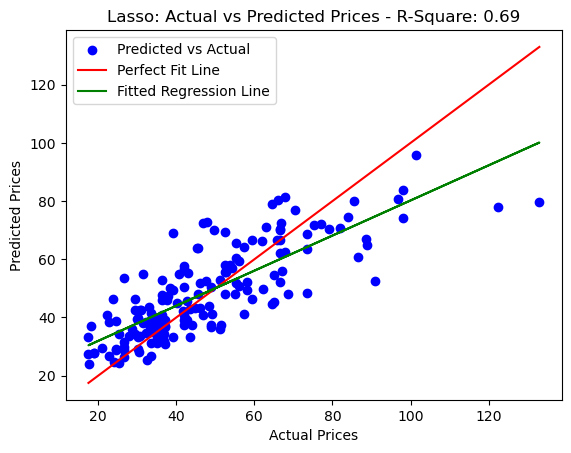


Lasso - GML: 156.35326239327938, RMSE: 12.504129813516787, R-squared: 0.6369274069713492


In [21]:
# lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# prediction on training
y_train_lasso = lasso_model.predict(X_train)
# predictions on test data
y_pred_lasso = lasso_model.predict(X_test)

# save Lasso performance metrics
lasso_r2_train = r2_score(y_train, y_train_lasso)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_rmse = lasso_mse ** 0.5
lasso_r2 = r2_score(y_test, y_pred_lasso)

plot_scatter("Lasso", y_test, y_pred_lasso, lasso_r2_train) # plot scatterplot
print(f"\nLasso - GML: {lasso_mse}, RMSE: {lasso_rmse}, R-squared: {lasso_r2}") # Report test data R-squared


----------------
$^{1}$ Harishkumar Datalab. (2022). Housing price prediction. Kaggle. https://www.kaggle.com/datasets/harishkumardatalab/housing-price-prediction